In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
random_state = 42

import python_code.Scripts as sc
import python_code.Reference as ref
import pickle
!pip install treeinterpreter

from sklearn.model_selection import train_test_split,StratifiedKFold,cross_val_score,GridSearchCV
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,recall_score,precision_score
from treeinterpreter import treeinterpreter as ti
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier,BaggingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

In [18]:
df = pd.read_csv("./data/final.csv")

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3904 entries, 0 to 3903
Data columns (total 33 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   FSASSET   3904 non-null   float64
 1   FSSLTDE2  3904 non-null   float64
 2   RAWERND   3904 non-null   float64
 3   SHELDED   3904 non-null   float64
 4   FSNONCIT  3904 non-null   float64
 5   CERTHHSZ  3904 non-null   float64
 6   WRK_POOR  3904 non-null   float64
 7   FSERNDED  3904 non-null   float64
 8   FSNETINC  3904 non-null   float64
 9   FSERNDE2  3904 non-null   float64
 10  FSUSIZE   3904 non-null   float64
 11  FSSSI     3904 non-null   float64
 12  TANF_IND  3904 non-null   float64
 13  REALPROP  3904 non-null   float64
 14  LIQRESOR  3904 non-null   float64
 15  FSWAGES   3904 non-null   float64
 16  FSCSEXP   3904 non-null   float64
 17  FSSTDDE2  3904 non-null   float64
 18  FSDIS     3904 non-null   float64
 19  FSSLTDED  3904 non-null   float64
 20  TPOV      3904 non-null   floa

In [20]:
X = df.drop(columns = ['CAT_ELIG'])
y = df['CAT_ELIG']

In [21]:
#baseline, NULL Model
y.value_counts(normalize=True)

CAT_ELIG
1.0    0.625512
2.0    0.374488
Name: proportion, dtype: float64

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.3,random_state=random_state)

In [23]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [24]:
np.savetxt('./data/TrainTest/X_train.csv',X_train,delimiter=',')
np.savetxt('./data/TrainTest/y_train.csv',y_train,delimiter=',')
np.savetxt('./data/TrainTest/X_test.csv',X_test,delimiter=',')
np.savetxt('./data/TrainTest/y_test.csv',y_test,delimiter=',')

In [25]:
pca = PCA(n_components=10,random_state=42)
pca.fit(X_train)
X_train_pc = pca.transform(X_train)
X_test_pc = pca.transform(X_test)

In [26]:
models = {
    'LogReg': LogisticRegression(),
    'Decision Tree':DecisionTreeClassifier(),
    'Random Forest':RandomForestClassifier(),
    'Gradient Boost':GradientBoostingClassifier(),
    'Ada Boost':AdaBoostClassifier(),
    'SVC':SVC(),
    'Naive Bayes':GaussianNB()}

In [39]:
# Build one row per model, then make the DataFrame once
cv4 = StratifiedKFold(n_splits=4, shuffle=False)

final = pd.DataFrame(columns=['name','cross_val_train','cross_val_test','test_recall','test_precision'])
idx=0
while idx < len(models.keys()):
    for name, model in models.items():
        results = {}
    
        results['name'] = name
        model.fit(X_train, y_train)
    
        y_pred_test = model.predict(X_test)
    
        results['cross_val_train'] = np.mean(cross_val_score(model, X_train, y_train, cv=cv4))
        results['cross_val_test']  = np.mean(cross_val_score(model,  X_test,  y_test,  cv=cv4))
        results['test_recall']     = recall_score(y_test, y_pred_test)        # add average='macro' if multiclass
        results['test_precision']  = precision_score(y_test, y_pred_test)     # add average='macro' if multiclass
    
        # modern replacement for .append:
        final.loc[len(final)] = results
        idx+=1

In [40]:
final = final.set_index('name')
final

,cross_val_train,cross_val_test,test_recall,test_precision
name,,,,
LogReg,0.799780,0.774744,0.882920,0.784578
Decision Tree,0.863836,0.874573,0.888430,0.909732
Random Forest,0.890190,0.910410,0.928375,0.927098
Gradient Boost,0.887262,0.899317,0.921488,0.920220
Ada Boost,0.848097,0.827645,0.904959,0.858824
SVC,0.812592,0.768771,0.928375,0.799526
Naive Bayes,0.678258,0.655290,0.803030,0.741730


In [41]:
pc_final = pd.DataFrame(columns=['name','cross_val_train','cross_val_test','test_recall','test_precision'])
idx=0
while idx < len(models.keys()):
    for name, model in models.items():
        results = {}
    
        results['name'] = name
        model.fit(X_train_pc, y_train)
    
        y_pred_test = model.predict(X_test_pc)
    
        results['cross_val_train'] = np.mean(cross_val_score(model, X_train_pc, y_train, cv=cv4))
        results['cross_val_test']  = np.mean(cross_val_score(model,  X_test_pc,  y_test,  cv=cv4))
        results['test_recall']     = recall_score(y_test, y_pred_test)        # add average='macro' if multiclass
        results['test_precision']  = precision_score(y_test, y_pred_test)     # add average='macro' if multiclass
    
        # replacement for .append:
        pc_final.loc[len(pc_final)] = results
        idx+=1

In [42]:
pc_final = pc_final.set_index('name')
pc_final

,cross_val_train,cross_val_test,test_recall,test_precision
name,,,,
LogReg,0.730966,0.721843,0.895317,0.723026
Decision Tree,0.744876,0.733788,0.816804,0.795973
Random Forest,0.803441,0.773891,0.878788,0.815857
Gradient Boost,0.794656,0.802901,0.870523,0.793970
Ada Boost,0.768668,0.761092,0.852617,0.777638
SVC,0.745242,0.742321,0.918733,0.737832
Naive Bayes,0.690337,0.676621,0.926997,0.674349


In [43]:
for name,model in models.items():
    name = model.fit(X_train,y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    print(name)
    print(classification_report(y_test, y_pred_test))
    print('\n')

LogisticRegression()
              precision    recall  f1-score   support

         1.0       0.78      0.88      0.83       726
         2.0       0.76      0.61      0.67       446

    accuracy                           0.78      1172
   macro avg       0.77      0.74      0.75      1172
weighted avg       0.78      0.78      0.77      1172



DecisionTreeClassifier()
              precision    recall  f1-score   support

         1.0       0.90      0.89      0.90       726
         2.0       0.83      0.85      0.84       446

    accuracy                           0.87      1172
   macro avg       0.87      0.87      0.87      1172
weighted avg       0.88      0.87      0.87      1172



RandomForestClassifier()
              precision    recall  f1-score   support

         1.0       0.92      0.93      0.92       726
         2.0       0.88      0.87      0.88       446

    accuracy                           0.91      1172
   macro avg       0.90      0.90      0.90      1172

In [45]:
rf = RandomForestClassifier(random_state=42)

params = {
    'max_depth': [None, 3, 4],
    'max_features': [None, 'sqrt', 'log2', 0.5],
    'n_estimators': [75, 100, 125]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rf_gs = GridSearchCV(
    rf,
    param_grid=params,
    cv=cv,
    scoring='accuracy',   # or your metric
    n_jobs=-1,
    error_score='raise'   # helpful while debugging
)

rf_gs.fit(X_train, y_train)
print(rf_gs.best_params_)
print(rf_gs.best_score_)

{'max_depth': None, 'max_features': None, 'n_estimators': 75}
0.9026297285895092


In [46]:
rf = RandomForestClassifier()
rf.fit(X_train,y_train)

RandomForestClassifier()

In [47]:
instances = X_test[[735]]
instances

array([[-0.24309398, -0.87253073, -0.59885312,  1.00652396,  1.78070948,
         1.02614408, -0.76825854, -0.59758589, -0.8826584 , -0.56404251,
         1.02614408, -0.42833737, -0.36488324, -0.03517855, -0.24501332,
        -0.55893964, -0.11792301, -1.59315573, -0.51403261,  1.0459183 ,
        -1.49056789,  0.86481274,  0.39411313, -0.12096324, -0.91848291,
        -0.1335093 , -0.59800159, -0.34230342, -0.88061189, -0.40909055,
        -0.02833014, -0.42334304]])

In [48]:
ft_list = []
prediction, bias, contributions = ti.predict(rf, instances)
print( "Prediction", prediction)
print( "Bias (trainset prior)", bias)
print ("Feature contributions:")
for c, feature in zip(contributions[0], 
                             X.columns):
    ft_list.append((feature, np.round(c, 2)))
    print (feature, c)
    
labels, values = zip(*ft_list)

Prediction [[0.27 0.73]]
Bias (trainset prior) [[0.6273243 0.3726757]]
Feature contributions:
FSASSET [ 0.03441905 -0.03441905]
FSSLTDE2 [-0.00263508  0.00263508]
RAWERND [ 0.01036784 -0.01036784]
SHELDED [-0.2091165  0.2091165]
FSNONCIT [-0.01821126  0.01821126]
CERTHHSZ [ 0.02310783 -0.02310783]
WRK_POOR [ 0.01221824 -0.01221824]
FSERNDED [ 0.01872888 -0.01872888]
FSNETINC [ 0.00555201 -0.00555201]
FSERNDE2 [ 0.00701828 -0.00701828]
FSUSIZE [ 0.05117233 -0.05117233]
FSSSI [-0.02547698  0.02547698]
TANF_IND [-0.02448467  0.02448467]
REALPROP [0. 0.]
LIQRESOR [ 0.02776559 -0.02776559]
FSWAGES [ 0.00974208 -0.00974208]
FSCSEXP [ 1.76253837e-05 -1.76253837e-05]
FSSTDDE2 [-0.03659892  0.03659892]
FSDIS [-0.00156295  0.00156295]
FSSLTDED [-0.16211411  0.16211411]
TPOV [ 0.00137435 -0.00137435]
FSNK0T4 [-0.02228041  0.02228041]
FSTOTDED [-0.00495073  0.00495073]
FSOTHUN [ 0.0010804 -0.0010804]
FSUNEARN [-0.04336971  0.04336971]
FSGA [-0.0044373  0.0044373]
FSEARN [ 0.01126122 -0.01126122]
F

In [49]:
df1 = pd.DataFrame(ft_list,columns=['feature','array'])
df2 = pd.DataFrame(df1["array"].to_list(), columns=['pred_0', 'pred_1'])
coef_df = pd.concat([df1,df2],axis=1).drop(columns=['array'])
coef_df.to_csv('./data/2018_indicators/coef.csv',index=None)

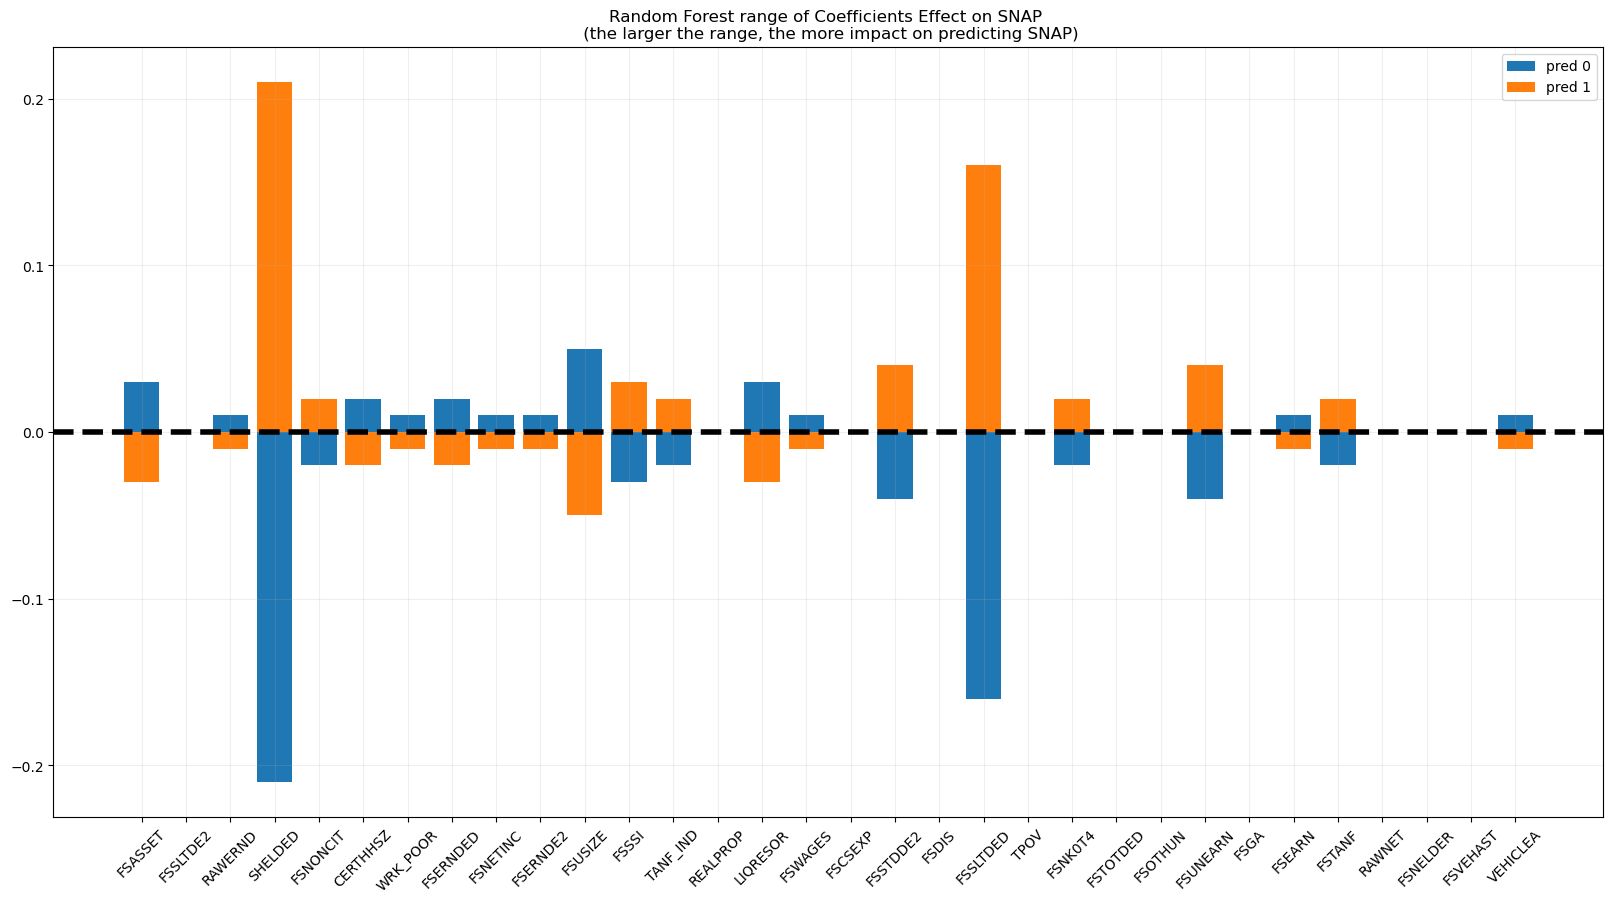

In [50]:
fig, ax = plt.subplots(figsize=(20,10))
plt.title('Random Forest range of Coefficients Effect on SNAP \n (the larger the range, the more impact on predicting SNAP)')
plt.grid(zorder=0,alpha = 0.2)
xs = np.arange(len(labels))
ax.bar(xs,coef_df['pred_0'], label = 'pred 0')
ax.bar(xs,coef_df['pred_1'],label = 'pred 1')
ax.axhline(y=0, linestyle='--', color='black', linewidth=4)
ax.set_xticks(coef_df.index)
ax.set_xticklabels(coef_df['feature'],rotation = 45)
plt.legend()
plt.savefig('./images/rf_corr.png');